In [1]:
import os

In [2]:
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification\\research'

In [3]:
os.chdir("../")


In [4]:
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification'

In [5]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [6]:
## Update the entity

from dataclasses import dataclass
from pathlib import Path

## Data Ingestion Entity
@dataclass(frozen = True)
class DataIngestionConfig:
    root_dir: Path
    dataset_name: str
    local_data_file: Path
    unzip_dir: Path
    class_weight: Path

@dataclass
class ModelTrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_input_shape : list
    params_batch_size : int
    params_learning_rate: float
    params_horizontal_flip: bool
    params_rotation_range: float
    params_zoom_range: float
    params_epochs: int
    params_dropout_rate: float
    params_weight_decay: float

@dataclass(frozen = True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path
    learning_rate: float


    

In [7]:
## Update configuration manager
from cnnclassifier.constants import *
from cnnclassifier.utils.common import *


class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 secret_filepath = SECRET_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.secret = read_yaml(secret_filepath)

        create_directories_files([self.config.artifacts_root])

    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        
        data_ingestion_config = DataIngestionConfig(
            root_dir = config.root_dir,
            dataset_name = config.dataset_name,
            local_data_file = config.local_data_file,
            unzip_dir = config.unzip_dir,
            class_weight = config.class_weight
            )
        return data_ingestion_config

    def get_callbacks_config(self)-> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        create_directories_files([config.root_dir])
        create_directories_files([config.tensorboard_root_log_dir])
        create_directories_files([os.path.dirname(config.checkpoint_model_filepath)])


        prepare_callbacks_config = PrepareCallbacksConfig(root_dir = Path(config.root_dir), 
                                                            tensorboard_root_log_dir= Path(config.tensorboard_root_log_dir),
                                                            checkpoint_model_filepath = Path(config.checkpoint_model_filepath),
                                                            learning_rate = self.params.learning_rate)
        
        return prepare_callbacks_config

    def get_model_trainer_config(self) -> ModelTrainingConfig:
        model_training = self.config.model_training
        prepare_base_model = self.config.prepare_base_model
        training_data = os.path.join(self.config.data_ingestion.local_data_file, "Train")
        create_directories_files([Path(model_training.root_dir)])


        model_training_config = ModelTrainingConfig(root_dir = Path(model_training.root_dir),
                                                    trained_model_path = Path(model_training.trained_model_path),
                                                    updated_base_model_path = Path(prepare_base_model.updated_base_model_path),
                                                    training_data = training_data,
                                                    params_input_shape = self.params.input_shape,
                                                    params_batch_size = self.params.batch_size,
                                                    params_learning_rate = self.params.learning_rate, 
                                                    params_horizontal_flip = self.params.horizontal_flip,
                                                    params_rotation_range = self.params.rotation_range,
                                                    params_zoom_range = self.params.zoom_range,
                                                    params_epochs = self.params.epochs, 
                                                    params_dropout_rate = self.params.dropout_rate,
                                                    params_weight_decay = self.params.weight_decay)
        return model_training_config

In [8]:
import tensorflow as tf
import time
class PrepareCallbacks:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(self.config.tensorboard_root_log_dir,
                                          f"tb_logs_at_{timestamp}")
        return tf.keras.callbacks.TensorBoard(log_dir = tb_running_log_dir)
    
    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(filepath = self.config.checkpoint_model_filepath, 
                                                  save_best_only = True)
    
    @property
    def _create_reduce_lr_callbacks(self):
        return tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", 
                                                    factor = 0.2, 
                                                    patience = 5, 
                                                    min_lr = self.config.learning_rate/1000)
    
    @property
    def _create_earlystopping_callbacks(self):
        return tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                patience = 10)
    
    def get_tb_ckpt_callbacks(self):
        return [self._create_tb_callbacks, 
                 self._create_ckpt_callbacks,
                 self._create_reduce_lr_callbacks, 
                 self._create_earlystopping_callbacks]





In [6]:
## Update Components

import tensorflow as tf
import os
import time
import json
from cnnclassifier.entity import DataIngestionConfig


In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
class ModelTraining:
    def __init__(self, config: ModelTrainingConfig, dataingestionconfig: DataIngestionConfig):
        self.config = config
        self.data_ingestion_config = dataingestionconfig

    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(self.config.updated_base_model_path)

    def train_valid_generator(self):
        valid_datagenerator_kwargs = dict(rescale = 1./255, 
                                    validation_split = 0.20)
        
        train_datagenerator_kwargs = dict(rescale = 1./255, 
                            validation_split = 0.20,
                            horizontal_flip = self.config.params_horizontal_flip,
                            rotation_range = self.config.params_rotation_range,
                            zoom_range = self.config.params_zoom_range)
        
        dataflow_kwargs = dict(target_size = self.config.params_input_shape[:-1], 
                               batch_size = self.config.params_batch_size,
                               interpolation = "bilinear")
        
        #** symbol is used for unpacking dictionaries into keyword arguments.
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**valid_datagenerator_kwargs)

        self.valid_generator = valid_datagenerator.flow_from_directory(self.config.training_data, 
                                                                       subset = "validation", 
                                                                       shuffle = True, 
                                                                       **dataflow_kwargs)
        
        train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(**train_datagenerator_kwargs)
        self.train_generator = train_datagenerator.flow_from_directory(self.config.training_data,
                                                                       subset = "training", shuffle = True, 
                                                                       **dataflow_kwargs)
        
    @staticmethod
    def save_model(path: Path , model: tf.keras.Model):
        model.save(path)

    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        with open(self.data_ingestion_config.class_weight, "r") as f:
            saved_weights = json.load(f)
        class_weight = {int(k): v for k,v in saved_weights.items()}


        self.model.fit(self.train_generator, 
                       epochs = self.config.params_epochs, 
                       steps_per_epoch = self.steps_per_epoch, 
                       validation_steps = self.validation_steps,
                       callbacks = callback_list, 
                       validation_data = self.valid_generator,
                       class_weight = class_weight
                       )
        
        self.save_model(path = self.config.trained_model_path,
                         model = self.model)
        


In [12]:
## Model Training Pipeline

try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config = prepare_callbacks_config)
    callbacks_lst = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_model_trainer_config()
    data_ingestion_config = config.get_data_ingestion_config()
    training = ModelTraining(config=training_config, dataingestionconfig=data_ingestion_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(callbacks_lst)
except Exception as e:
    raise e

[2024-09-03 14:09:04,680: INFO : common : config\config.yaml loaded successfully]
[2024-09-03 14:09:04,687: INFO : common : params\params.yaml loaded successfully]
[2024-09-03 14:09:04,689: INFO : common : secrets\secrets.yaml loaded successfully]
[2024-09-03 14:09:04,691: INFO : common : Parent Directories and Files Successfully Created]
[2024-09-03 14:09:04,694: INFO : common : Parent Directories and Files Successfully Created]
[2024-09-03 14:09:04,697: INFO : common : Parent Directories and Files Successfully Created]
[2024-09-03 14:09:04,699: INFO : common : Parent Directories and Files Successfully Created]
[2024-09-03 14:09:04,702: INFO : common : Parent Directories and Files Successfully Created]
Found 1610 images belonging to 8 classes.
Found 6457 images belonging to 8 classes.
Epoch 1/500
807/807 [==============================] - 99s 112ms/step - loss: 20.0447 - accuracy: 0.5343 - precision: 0.8379 - recall: 0.3318 - val_loss: 7.8220 - val_accuracy: 0.5243 - val_precision: 0.

In [10]:
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification\\research'

In [11]:
os.chdir("../")
%pwd

'd:\\Artificial Intelligence and Machine Learning\\End2End Projects\\chicken-disease-classification'

In [16]:
from keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from pathlib import Path
import tensorflow as tf

In [17]:
model = load_model(r'artifacts\model_training\model.h5')

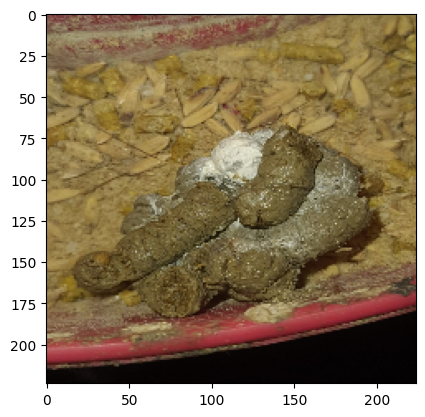

In [18]:
img = plt.imread(r"artifacts\data_ingestion\test.jpeg")
img = tf.image.resize(img, [224,224])
img = img/255.0
plt.imshow(img)


In [19]:
img = np.expand_dims(img, axis = 0)
img.shape

(1, 224, 224, 3)

In [28]:
preds = {}
main_dir = Path("artifacts\data_ingestion\Train")
cnt = 0
for item in main_dir.iterdir():
    if item.is_dir():
        preds[cnt] = item.name
    cnt+=1


In [29]:
preds

{0: 'cocci',
 1: 'healthy',
 2: 'ncd',
 3: 'pcrcocci',
 4: 'pcrhealthy',
 5: 'pcrncd',
 6: 'pcrsalmo',
 7: 'salmo'}

In [31]:
pred = np.argmax(model.predict_on_batch(img))
print(str.upper(f"your chicken has been found to be {preds[pred]}"))

YOUR CHICKEN HAS BEEN FOUND TO BE PCRHEALTHY
